# Final Year Project # 
* **Tittle:** Formulation of a Deep Learning Model for the Automated Detection via Segmentation of Lung Cancer
* **Model:** DeepLabV3 https://arxiv.org/abs/1802.02611v3
* **Encoder:** ResNet50 & ResNet 101
* **Fixed Hyperparameter:** learning rate, activation function
* **Tweerked Hyperparamter:** optimizer, loss function
* **Dataset:** CT images from http://medicaldecathlon.com/


**Install All Necessary Libraries**

In [1]:
pip install comet_ml

     |████████████████████████████████| 347 kB 3.1 MB/s            
     |████████████████████████████████| 54 kB 2.3 MB/s             
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 551 kB 56.9 MB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19191 sha256=cbae65db019589a10e132daff71ebfbb8e949ed972bd1078410806718a6c366e
  Stored in directory: /root/.cache/pip/wheels/df/99/da/c34f202dc8fd1dffd35e0ecf1a7d7f8374ca05fbcbaf974b83
  Created wheel for configobj: filename=configobj-5.0.6-py3-none-any.whl size=34546 sha256=6a12e7f5f74e7bfe8d557a81b274daae7ecc9cd53d7775b1f1749b62be5f4414
  Stored in directory: /root/.cache/pip/wheels/0d/c4/19/13d74440f2a571841db6b6e0a273694327498884dafb9cf978
Successfully built nvidia-ml-py3 configobj
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install moviepy

     |████████████████████████████████| 388 kB 3.1 MB/s            
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 26.9 MB 53.4 MB/s            
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110744 sha256=2d702af95031defb0713495573ec0ba156da3c738921fb743e3778e6b76772bd
  Stored in directory: /root/.cache/pip/wheels/56/dc/2b/9cd600d483c04af3353d66623056fc03faed76b7518faae4df
  Created wheel for proglog: filename=proglog-0.1.9-py3-none-any.whl size=6157 sha256=43baf32376e87989312783626ec8845e58f5481c0fabcfee052e5265f06fd70a
  Stored in directory: /root/.cache/pip/wheels/12/36/1f/dc61e6ac10781d63cf6fa045eb09fa613a667384e12cb6e6e0
Successfully built moviepy proglog
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.0
    Uninstalling decorator-5.1.0:
      Successfully uninstalled decorator-5.1.0
ERROR: pip's dependency resolver does not currently tak

In [3]:
pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-1va0nq14
  Running command git clone --filter=blob:none -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-1va0nq14
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 740dab561ccf54a9ae4bb5bda3b8b18df3790025
  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - \ | / done
  Preparing metadata (pyproject.toml) ... - \ | / done
     |████████████████████████████████| 58 kB 2.1 MB/s             
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 376 kB 6.1 MB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.0.dev0-py3-none-any.whl size=98008 sha256=08ddabf7a3343ab7c45f8a2e6a7fc752ae35f1efc00b486c8259bf3a67125626
  Stored in directory: /tmp/pip-ephem-wheel-cache-z

**Import Library**

In [4]:
import segmentation_models_pytorch as smp  #segmentation model
import comet_ml  #logger
import torch
import torchmetrics
import torchvision
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CometLogger
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt
from moviepy.video.io.bindings import mplfig_to_npimage
from tqdm.notebook import tqdm
from comet_ml import Experiment
from pathlib import Path

from dataset import LungDataset

# Loss Function

In [5]:
class BinaryFocalLoss(torch.nn.Module):
    """
    This is a implementation of Focal Loss with smooth label cross entropy supported which is proposed in
    'Focal Loss for Dense Object Detection. (https://arxiv.org/abs/1708.02002)'
        Focal_Loss= -1*alpha*(1-pt)*log(pt)
    :param alpha: (tensor) 3D or 4D the scalar factor for this criterion
    :param gamma: (float,double) gamma > 0 reduces the relative loss for well-classified examples (p>0.5) putting more
                    focus on hard misclassified example
    :param reduction: `none`|`mean`|`sum`
    :param **kwargs
        balance_index: (int) balance class index, should be specific when alpha is float
    """

    def __init__(self, alpha=0.8, gamma=2, ignore_index=None, reduction='mean', **kwargs):
        super(BinaryFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = 1e-6  # set '1e-4' when train with FP16
        self.ignore_index = ignore_index
        self.reduction = reduction

        assert self.reduction in ['none', 'mean', 'sum']

        # if self.alpha is None:
        #     self.alpha = torch.ones(2)
        # elif isinstance(self.alpha, (list, np.ndarray)):
        #     self.alpha = np.asarray(self.alpha)
        #     self.alpha = np.reshape(self.alpha, (2))
        #     assert self.alpha.shape[0] == 2, \
        #         'the `alpha` shape is not match the number of class'
        # elif isinstance(self.alpha, (float, int)):
        #     self.alpha = np.asarray([self.alpha, 1.0 - self.alpha], dtype=np.float).view(2)

        # else:
        #     raise TypeError('{} not supported'.format(type(self.alpha)))

    def forward(self, output, target):
        prob = torch.sigmoid(output)
        #prob = output
        prob = torch.clamp(prob, self.smooth, 1.0 - self.smooth)

        valid_mask = None
        if self.ignore_index is not None:
            valid_mask = (target != self.ignore_index).float()

        pos_mask = (target == 1).float()
        neg_mask = (target == 0).float()
        if valid_mask is not None:
            pos_mask = pos_mask * valid_mask
            neg_mask = neg_mask * valid_mask

        pos_weight = (pos_mask * torch.pow(1 - prob, self.gamma)).detach()
        pos_loss = -pos_weight * torch.log(prob)  # / (torch.sum(pos_weight) + 1e-4)

        neg_weight = (neg_mask * torch.pow(prob, self.gamma)).detach()
        neg_loss = -self.alpha * neg_weight * F.logsigmoid(-output)  # / (torch.sum(neg_weight) + 1e-4)
        loss = pos_loss + neg_loss
        loss = loss.mean()
        return loss

In [6]:
class DiceLoss(torch.nn.Module):
    """
    class to compute the Dice Score
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
                
        #flatten label and prediction tensors
        #pred = torch.sigmoid(pred)
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        
        counter = (pred * mask).sum()  # Counter       
        denum = pred.sum() + mask.sum() +1e-8 # denominator
        dice = (2*counter)/denum
        
        return 1-dice

**Model & Hyperparameter  (change here only)**
1. Encoder
2. Optimizer
3. Loss Function

In [7]:
ENCODER = 'resnet50' #resnet50 or resnet101
OPTIMIZER = torch.optim.SGD #Adam / SGD / Adagrad
LOSSFUNC = DiceLoss()  # torch.nn.BCEWithLogitsLoss() / DiceLoss() / BinaryFocalLoss()

In [8]:
EXPERIMENTNAME = "deeplabv3_resnet50_sgd_diceloss"

In [9]:
if (OPTIMIZER == torch.optim.Adam) :
    LEARNINGRATE = 0.001;
if (OPTIMIZER == torch.optim.SGD) :
    LEARNINGRATE = 0.01;
if (OPTIMIZER == torch.optim.Adagrad) :
    LEARNINGRATE = 0.001;

**Model Used**

In [10]:
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
INPUT_CHANNEL = 1
OUTPUT_CLASS = 1 
 
# create segmentation model with pretrained encoder
seg_model = smp.DeepLabV3(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    activation=ACTIVATION,
    in_channels=INPUT_CHANNEL,
    classes=OUTPUT_CLASS,  
)
seg_model.eval;

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

**Comet Logger**

In [11]:
experiment = Experiment(
    api_key="O2XxPhsYt1pyLQfm7aUzA3BCi",
    project_name="fyp-lung-cancer-seg",
)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/yeezhing/fyp-lung-cancer-seg/b0a635c08ee84220b72308353c3bc1b1



# Dataset Processing

In [12]:
seq = iaa.Sequential([
    iaa.Affine(translate_percent=(0.15), 
               scale=(0.85, 1.15), # zoom in or out
               rotate=(-45, 45)#
               ),  # rotate up to 45 degrees
    iaa.ElasticTransformation()  # Elastic Transformations
                ])

In [13]:
# load dataset

train_path = Path("../input/balanced-data/Preprocessed/train/")
val_path = Path("../input/balanced-data/Preprocessed/val/")

train_dataset = LungDataset(train_path, seq)
val_dataset = LungDataset(val_path, None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

COMET WARNING: Error exporting current conda environment


There are 14484 train images and 1691 val images


**Apply WeightedRandomSampler to overcome imbalance dataset**

In [14]:
target_list = []
for _, label in tqdm(train_dataset):
    # Check if mask contains a tumorous pixel:
    if np.any(label):
        target_list.append(1)
    else:
        target_list.append(0)

  0%|          | 0/14484 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


In [15]:
uniques = np.unique(target_list, return_counts=True)
fraction = uniques[1][0] / uniques[1][1]

weight_list = []
for target in target_list:
    if target == 0:
        weight_list.append(1)
    else:
        weight_list.append(fraction)
        
sampler = torch.utils.data.sampler.WeightedRandomSampler(weight_list, len(weight_list),replacement=True)  

In [16]:
#create dataloader

batch_size = 5#TODO
num_workers = 2# TODO


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           num_workers=num_workers, sampler=sampler )
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, num_workers=num_workers, shuffle=True)

In [17]:
verify_sampler = next(iter(train_loader))  # Take one batch
(verify_sampler[1][:,0]).sum([1, 2]) > 0   # ~ half the batch size 

tensor([ True, False,  True, False, False])

# Performance Metrics

In [18]:
#performance metrics

class DiceScore(torch.nn.Module):
    """
    class to compute the Dice Score
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
                
        #flatten label and prediction tensors
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        
        counter = (pred * mask).sum()  # Counter       
        denum = pred.sum() + mask.sum() +1e-8 # denominator
        dice = (2*counter)/denum
        
        return dice

class IOU(torch.nn.Module):
    """
    class to compute the Intersection of Union
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
                
        #flatten label and prediction tensors
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        
        intersection = torch.sum(pred * mask)
        IoU = (intersection + 1.0) / (torch.sum(mask) + torch.sum(pred) - intersection + 1.0)
        
        return IoU

# Training Process

In [19]:
class TumorSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = seg_model

        self.optimizer = OPTIMIZER(self.model.parameters(), lr=LEARNINGRATE)
        self.loss_fn = LOSSFUNC
        
        self.Dice_Score = DiceScore()
        self.IoU = IOU()
        self.Accuracy = torchmetrics.Accuracy()
        
        self.preds = []
        self.labels = []
    
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        ct, mask = batch
        mask = mask.float()
        ct = ct.float()
        
        pred = self(ct)
        loss = self.loss_fn(pred, mask)
        
        # Logs
        comet_logger.experiment.log_metric("Train Loss", loss, epoch=self.current_epoch)
        if batch_idx % 100 == 0:
            self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), "Train")
        
        return loss
    
        
    def validation_step(self, batch, batch_idx):
        ct, mask = batch
        mask = mask.float()
        ct = ct.float()
        
        pred = self(ct)
        loss = self.loss_fn(pred, mask)
        
        pred_m = pred > 0.5
        pred_m = pred_m.float()*1
        self.preds.append(pred_m.cpu().numpy())
        self.labels.append(mask.cpu().numpy())

        
        # Logs
        comet_logger.experiment.log_metric("Val Loss", loss, epoch=self.current_epoch)
        if batch_idx % 100 == 0:
            self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), "Val")
        
        return loss

    def validation_epoch_end(self, outputs):
        self.preds = np.array(self.preds)
        self.labels = np.array(self.labels)
        self.labels = self.labels > 0.5
        self.labels = self.labels*1
        
        dice_score = self.Dice_Score(torch.from_numpy(self.preds),torch.from_numpy(self.labels))
        IoU_metric = self.IoU(torch.from_numpy(self.preds),torch.from_numpy(self.labels))
        accuracy = self.Accuracy(torch.from_numpy(self.preds),torch.from_numpy(self.labels))
        comet_logger.experiment.log_metric("Val Dice", dice_score, epoch=self.current_epoch)
        comet_logger.experiment.log_metric("Val IoU", IoU_metric, epoch=self.current_epoch)
        comet_logger.experiment.log_metric("Val Accuracy", accuracy, epoch=self.current_epoch)
        
        self.preds = []
        self.labels = []
    
    def log_images(self, ct, pred, mask, name):
        
        results = []
        pred = pred > 0.5
        epoch_num = self.current_epoch
        
        #np_mask = mask.cpu().detach().numpy()
        #np_ct = ct.cpu().detach().numpy()
        #np_pred = pred.cpu().detach().numpy()
        
        plt.cla()
        plt.close()
        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(ct[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0]==0, mask[0][0])
        axis[0].imshow(mask_, alpha=0.6)
        axis[0].set_title("Ground Truth")
        
        axis[1].imshow(ct[0][0], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][0]==0, pred[0][0])
        axis[1].imshow(mask_, alpha=0.6, cmap="autumn")
        axis[1].set_title("Prediction")
        
        numpy_fig = mplfig_to_npimage(fig)

        comet_logger.experiment.log_image(numpy_fig, f"{name} Prediction vs Label {epoch_num}")

            
    
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]



In [20]:
comet_logger = CometLogger(
    api_key="O2XxPhsYt1pyLQfm7aUzA3BCi",
    project_name="fyp-lung-cancer-seg",
    workspace="yeezhing",
    experiment_name= EXPERIMENTNAME,  # Optional
)

In [21]:
model = TumorSegmentation() 
if torch.cuda.is_available():
    model.cuda()
model.eval();

In [22]:
checkpoint_callback = ModelCheckpoint(
    monitor='Val BCE',
    save_top_k=30,
    mode='min')

In [23]:
gpus = 1 #TODO
trainer = pl.Trainer(gpus=gpus, logger=comet_logger, log_every_n_steps=1,
                     callbacks=checkpoint_callback,max_epochs=30)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/yeezhing/fyp-lung-cancer-seg/b0a635c08ee84220b72308353c3bc1b1
COMET INFO:   Uploads:
COMET INFO:     conda-info          : 1
COMET INFO:     conda-specification : 1
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET WARNING: Comet has disabled auto-logging functionality as it has been impor

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:373: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  f"Your {mode}_dataloader has `shuffle=True`, it is best practice to turn"
COMET WARNING: Error exporting current conda environment


Training: -1it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
COMET ERROR: File could not be uploaded: RetryError(MaxRetryError("HTTPSConnectionPool(host='www.comet-ml.com', port=443): Max retries exceeded with url: /clientlib/visualizations/upload?experimentId=1587b6cfaf2a4fe69d94f684782c4a30&projectId=60ab258b9c7c48e2a9fa9a66425e1286&apiKey=*********REDACTED**

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validating: 0it [00:00, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/yeezhing/fyp-lung-cancer-seg/1587b6cfaf2a4fe69d94f684782c4a30
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Train Loss [86910] : (0.025146007537841797, 1.0)
COMET INFO:     Val Accuracy [31]  : (0.8609466552734375, 0.9996364712715149)
COMET INFO:     Val Dice [31]      : (0.0, 0.8059550523757935)
COMET INFO:     Val IoU [31]       : (5.486366353579797e-05, 0.674981415271759)
COMET INFO:     Val Loss [50732]   : (0.04751181602478027, 1.0)
COMET INFO:   Others:
COMET INFO:     Name : deeplabv3_resnet50_sgd_diceloss
COMET INFO:   Uploads:
COMET INFO:     conda-info          : 1
COMET INFO:     conda-specification : 1
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     images              : 1381


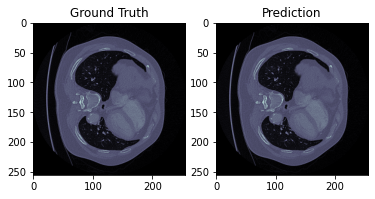

In [24]:
trainer.fit(model, train_loader, val_loader)

In [25]:
torch.save(model, 'my_model')
comet_logger.experiment.log_model('model', './my_model')
experiment.end()

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/yeezhing/fyp-lung-cancer-seg/1587b6cfaf2a4fe69d94f684782c4a30



In [26]:
model = torch.load("./my_model")
model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device);

In [27]:
preds = []
labels = []

for slice, label in tqdm(val_dataset):
    slice = torch.tensor(slice).float().to(device).unsqueeze(0)
    with torch.no_grad():
        pred = model(slice)
        pred = pred > 0.5
        pred = pred.float()*1
    preds.append(pred.cpu().numpy())
    labels.append(label)
    
preds = np.array(preds)
labels = np.array(labels)

  0%|          | 0/1691 [00:00<?, ?it/s]

In [28]:
dice_score = DiceScore()(torch.from_numpy(preds), torch.from_numpy(labels).unsqueeze(0).float())
IoU_metric = IOU()(torch.from_numpy(preds), torch.from_numpy(labels).unsqueeze(0).float())
print(f"The Val Dice Score is: {dice_score}")
print(f"The Val IoU is: {IoU_metric}")

The Val Dice Score is: 0.8031294345855713
The Val IoU is: 0.6710271239280701
